In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

df = pd.read_csv("C:\\Users\\lclai\\Desktop\\research LDIG\\data_dementia\\clean\\pitt_clean.csv")
df = df[(df['label'] == 0) | (df['label'] == 1)]

sex = df["sex"].map({"M": 0, "F": 1}).to_numpy().reshape(-1, 1)
age = df['age'].to_numpy().reshape(-1, 1)
X_text = vectorizer.fit_transform(df["clean_transcripts"]).toarray()

x_numeric = np.hstack((age, X_text))
x_scaled = StandardScaler().fit_transform(x_numeric)

X = np.hstack((sex, x_scaled))


y = LabelEncoder().fit_transform(df["label"])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation AUC: 0.9214
AUC on test set: 0.9004
Accuracy on test set: 0.8000

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.78        49
           1       0.76      0.88      0.82        51

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



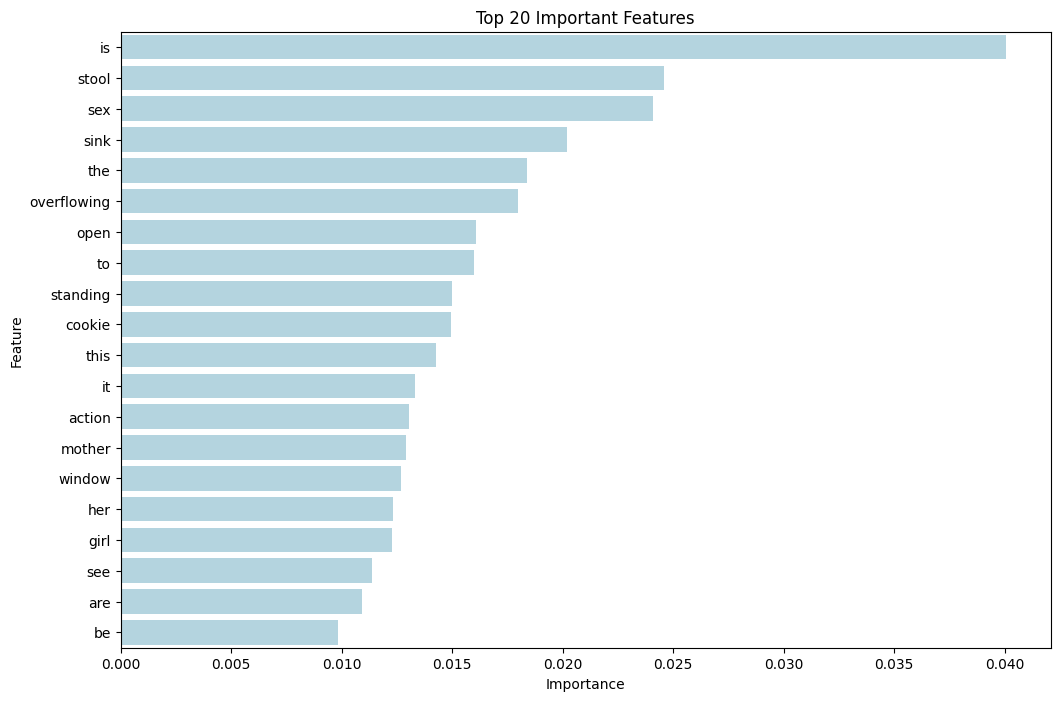

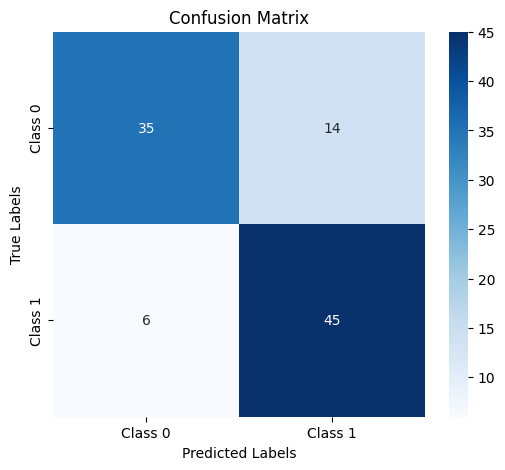

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [500,1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_

y_pred = best_clf.predict(X_test)
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")
print(f"AUC on test set: {auc_score:.4f}")
print(f"Accuracy on test set: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

importances = best_clf.feature_importances_

feature_names = np.concatenate([["age", "sex"], vectorizer.get_feature_names_out()])
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), color='lightblue')  
plt.title('Top 20 Important Features')
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

param_grid = {
    'n_estimators': [300,500,1000],  
    'max_depth': [3, 6],  
    'learning_rate': [0.01, 0.1, 0.3],  
    'subsample': [0.8, 1.0],  

}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_

y_pred = cross_val_predict(best_clf, X_test, y_test, cv=5)

auc = roc_auc_score(y_test, y_pred)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")
print(auc)


Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}
Best cross-validation AUC: 0.8864
0.7394957983193277


In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


if isinstance(X_train, np.ndarray):
    
    X_train = pd.DataFrame(X_train, columns=column_names)

if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=column_names)


xgb_clf = xgb.XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.01, subsample=0.8, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Validación Cruzada Estratificada (CV=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_xgb_folds = []
auc_rf_folds = []
auc_ensemble_folds = []

for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Entrenar modelos en el fold actual
    xgb_clf.fit(X_train_fold, y_train_fold)
    rf_clf.fit(X_train_fold, y_train_fold)
    
    # Predicciones de probabilidad en el fold actual
    pred_xgb = xgb_clf.predict_proba(X_val_fold)[:, 1]
    pred_rf = rf_clf.predict_proba(X_val_fold)[:, 1]
    
    # Ensemble: Promedio de las probabilidades
    pred_ensemble = (pred_xgb + pred_rf) / 2
    
    # Calcular AUC en este fold
    auc_xgb_folds.append(roc_auc_score(y_val_fold, pred_xgb))
    auc_rf_folds.append(roc_auc_score(y_val_fold, pred_rf))
    auc_ensemble_folds.append(roc_auc_score(y_val_fold, pred_ensemble))

# 1️⃣ Mean AUC CV para cada modelo
mean_auc_xgb = np.mean(auc_xgb_folds)
mean_auc_rf = np.mean(auc_rf_folds)
mean_auc_ensemble = np.mean(auc_ensemble_folds)

# 2️⃣ Entrenar modelos en Train Set completo
xgb_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# 3️⃣ Predicción en Test Set
pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
pred_rf = rf_clf.predict_proba(X_test)[:, 1]
pred_ensemble = (pred_xgb + pred_rf) / 2

# 4️⃣ Evaluación en Test Set
auc_test = roc_auc_score(y_test, pred_ensemble)

# 5️⃣ Matriz de Confusión en Test Set
y_pred_final = (pred_ensemble >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_final)

# 6️⃣ Mostrar Resultados
print(f"Mean AUC CV (XGBoost): {mean_auc_xgb:.4f}")
print(f"Mean AUC CV (Random Forest): {mean_auc_rf:.4f}")
print(f"Mean AUC CV (Ensemble XGB+RF): {mean_auc_ensemble:.4f}")
print(f"AUC on Test Set (Ensemble XGB+RF): {auc_test:.4f}")

# 7️⃣ Graficar la Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [6]:
# softmax

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Modelo correcto para clases binarias
log_reg = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=42)

# Grid de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],  
    'max_iter': [100, 200, 500]  
}

# GridSearch con validación cruzada (cv=5)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicciones en Test Set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

# AUC en Test Set
auc = roc_auc_score(y_test, y_pred_proba)

# Resultados
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejores parámetros: {grid_search.best_score_}")
print(f"AUC: {auc:.4f}")


Mejores parámetros: {'C': 10, 'max_iter': 100}
Mejores parámetros: 0.9094009413778348
AUC: 0.9136


c:\Users\lclai\miniconda3\envs\envlaia\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
